In [13]:
import os
import glob
import time
import numpy as np
from PIL import Image
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torch.utils.data import DataLoader

import sys
sys.path.append('../src')
from dataset import ColorizationDataset
from model import MainModel
from loss import AverageMeter

from dotenv import load_dotenv
load_dotenv()


True

In [2]:
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 400000
SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_DIR = os.path.join(os.getenv('DATASET_PATH'), "coco-2017-dataset")

In [3]:
DATA_DIR

'D:\\\\AIDS\\\\S2\\\\Project\\coco-2017-dataset'

In [5]:
paths = glob.glob(DATA_DIR+"/coco2017/train2017/*.jpg")
train_paths = paths[:16000] 
val_paths = paths[16000:]
print(len(train_paths), len(val_paths))

16000 4000


In [6]:
def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, size = SIZE, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(size= size, **kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [7]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

data = next(iter(train_dl))
Ls, abs_ = data['L'], data['ab']
print(Ls.shape, abs_.shape)
print(len(train_dl), len(val_dl))

torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
1000 250


In [8]:
model = MainModel()

model initialized with norm initialization
model initialized with norm initialization


In [9]:
def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        ax = plt.subplot(3, 5, i + 1)
        ax.imshow(L[i][0].cpu(), cmap='gray')
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

In [15]:
df = pd.DataFrame(columns=['loss_D_fake', 'loss_D_real', 'loss_D', 'loss_G_GAN', 'loss_G_L1', 'loss_G'])

  0%|          | 0/1000 [00:00<?, ?it/s]


Epoch 1/30
Iteration 200/1000
loss_D_fake: 0.46893
loss_D_real: 0.47532
loss_D: 0.47212
loss_G_GAN: 1.58352
loss_G_L1: 9.47730
loss_G: 11.06082


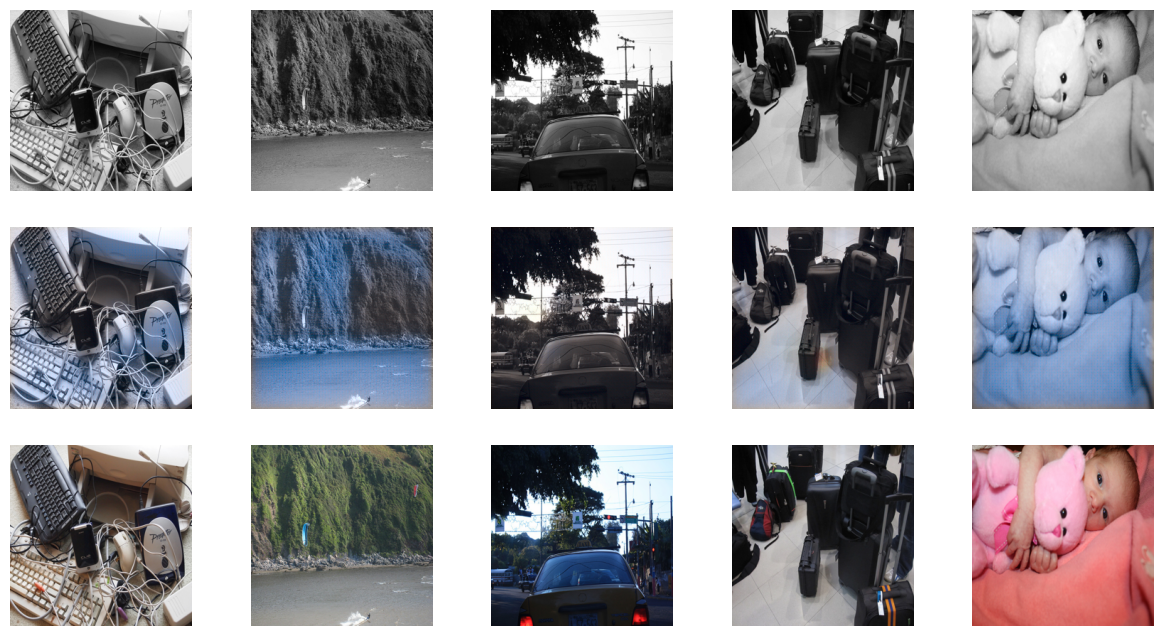

KeyboardInterrupt: 

In [10]:
def train_model(model, train_dl, epochs, display_every=200):
    loss_history = []  # List to store loss history
    data = next(iter(val_dl)) # getting a batch for visualizing the model output after fixed intervals
    for e in range(epochs):
        loss_meter_dict = create_loss_meters() # function returning a dictionary of objects to log the losses of the complete network
        i = 0
        for data in tqdm(train_dl):
            model.setup_input(data) 
            model.optimize()
            update_losses(model, loss_meter_dict, count=data['L'].size(0)) # function updating the log objects
            i += 1
            if i % display_every == 0:
                print(f"\nEpoch {e+1}/{epochs}")
                print(f"Iteration {i}/{len(train_dl)}")
                log_results(loss_meter_dict) # function to print out the losses
                if(e % 5 == 0 ):
                    visualize(model, data, save=False) # function displaying the model's outputs
            pd.concat([df, loss_meter_dict])
    return loss_history

loss_history = train_model(model, train_dl, 30)

In [ ]:
torch.save(model.state_dict(), 'normal_gan.pt')
np.save('normal_gan.npy', loss_history)

In [26]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet


def build_res_unet(n_input=1, n_output=2, size=256):
    body = create_body(resnet18(), pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(DEVICE)
    return net_G

In [28]:
def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
    loss_history = []  # List to store loss history
    for e in range(epochs):
        loss_meter = AverageMeter()
        for data in tqdm(train_dl):
            L, ab = data['L'].to(DEVICE), data['ab'].to(DEVICE)
            preds = net_G(L)
            loss = criterion(preds, ab)
            opt.zero_grad()
            loss.backward()
            opt.step()
            
            loss_meter.update(loss.item(), L.size(0))
        
        loss_history.append(loss_meter.avg)  # Append loss to history
        
        print(f"Epoch {e + 1}/{epochs}")
        print(f"L1 Loss: {loss_meter.avg:.5f}")

    np.save('res18-unet.npy', loss_history)  # Save loss history as .npy file

net_G = build_res_unet(n_input=1, n_output=2, size=256)
opt = optim.Adam(net_G.parameters(), lr=1e-4)
criterion = nn.L1Loss()        
pretrain_generator(net_G, train_dl, opt, criterion, 20)
torch.save(net_G.state_dict(), "res18-unet.pt")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1/20
L1 Loss: 0.08652


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/20
L1 Loss: 0.08287


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/20
L1 Loss: 0.08222


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/20
L1 Loss: 0.08141


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/20
L1 Loss: 0.08081


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/20
L1 Loss: 0.08026


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load("res18-unet.pt", map_location=device))
model = MainModel(net_G=net_G)
train_model(model, train_dl, 10)

In [ ]:
torch.save(model.state_dict(), 'resnet_gan.pt')
np.save('resnet_gan.npy', loss_history)